<a href="https://colab.research.google.com/github/ee-689-boun/tsdl/blob/main/gluonts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I implemented some of models we mentioned, namely **DeepAR**, **DeepState**, **DeepFactor** (we did not mention this, I found them on the documentation) and a **simple feed forward network**. I finished with the comparison of the methods with the selected metrics, MAPE and RMSE - can be easily increased - 

Other available models can be found here:
https://ts.gluon.ai/api/gluonts/gluonts.model.html

#### Notes:

- Some models like deepstate can work with multiple items at the same time, so maybe we can add pound/usd or jpy/eur etc. to see whether they improve the performance or not.
- I played with the hyperparameters but I think we need to analyze them more. And to keep the running fast, I selected small numbers of epochs. I think we have to increase them before the report. 
- We can run classic time series model that are implemented in R from gluonts library, but I couldn't succeed. 

#### References:
- https://aws.amazon.com/tr/blogs/machine-learning/creating-neural-time-series-models-with-gluon-time-series/
- https://ts.gluon.ai/#get-started-a-quick-example

In [61]:
!pip install mxnet gluonts

# installing R packages, requires for GluonTS R wrapper, but I couldn't make it work, so for now no need to install
# !pip install 'rpy2>=2.9.*,<3.*'
# !R -e 'install.packages(c("forecast", "nnfor"), repos="https://cloud.r-project.org")'

# Data Preparation

In [62]:
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas

In [63]:
# I uploaded csv file to colab
inv_data = pd.read_csv("EUR_USD_Data.csv", 
                       low_memory=False, 
                       usecols=["Date", "Price"], 
                       parse_dates=["Date"], 
                       index_col="Date")
inv_data = inv_data.sort_index()
inv_data.index.freq = "1B"

In [64]:
# ensure that we only have weekdays
inv_data.index.dayofweek.value_counts()

4    213
3    213
2    213
1    213
0    213
Name: Date, dtype: int64

In [65]:
test_length, valid_length = 20, 20

train = inv_data.iloc[:-(test_length + valid_length)]
valid = inv_data.iloc[-(test_length + valid_length):-valid_length]
test = inv_data.iloc[-valid_length:]
train_valid = pd.concat([train, valid]) # use this if you won't need a validation set

print("train start-end dates:", train.index[[0, -1]].values)
print("valid start-end dates:", valid.index[[0, -1]].values)
print("test start-end dates:", test.index[[0, -1]].values)

train start-end dates: ['2017-01-02T00:00:00.000000000' '2020-12-04T00:00:00.000000000']
valid start-end dates: ['2020-12-07T00:00:00.000000000' '2021-01-01T00:00:00.000000000']
test start-end dates: ['2021-01-04T00:00:00.000000000' '2021-01-29T00:00:00.000000000']


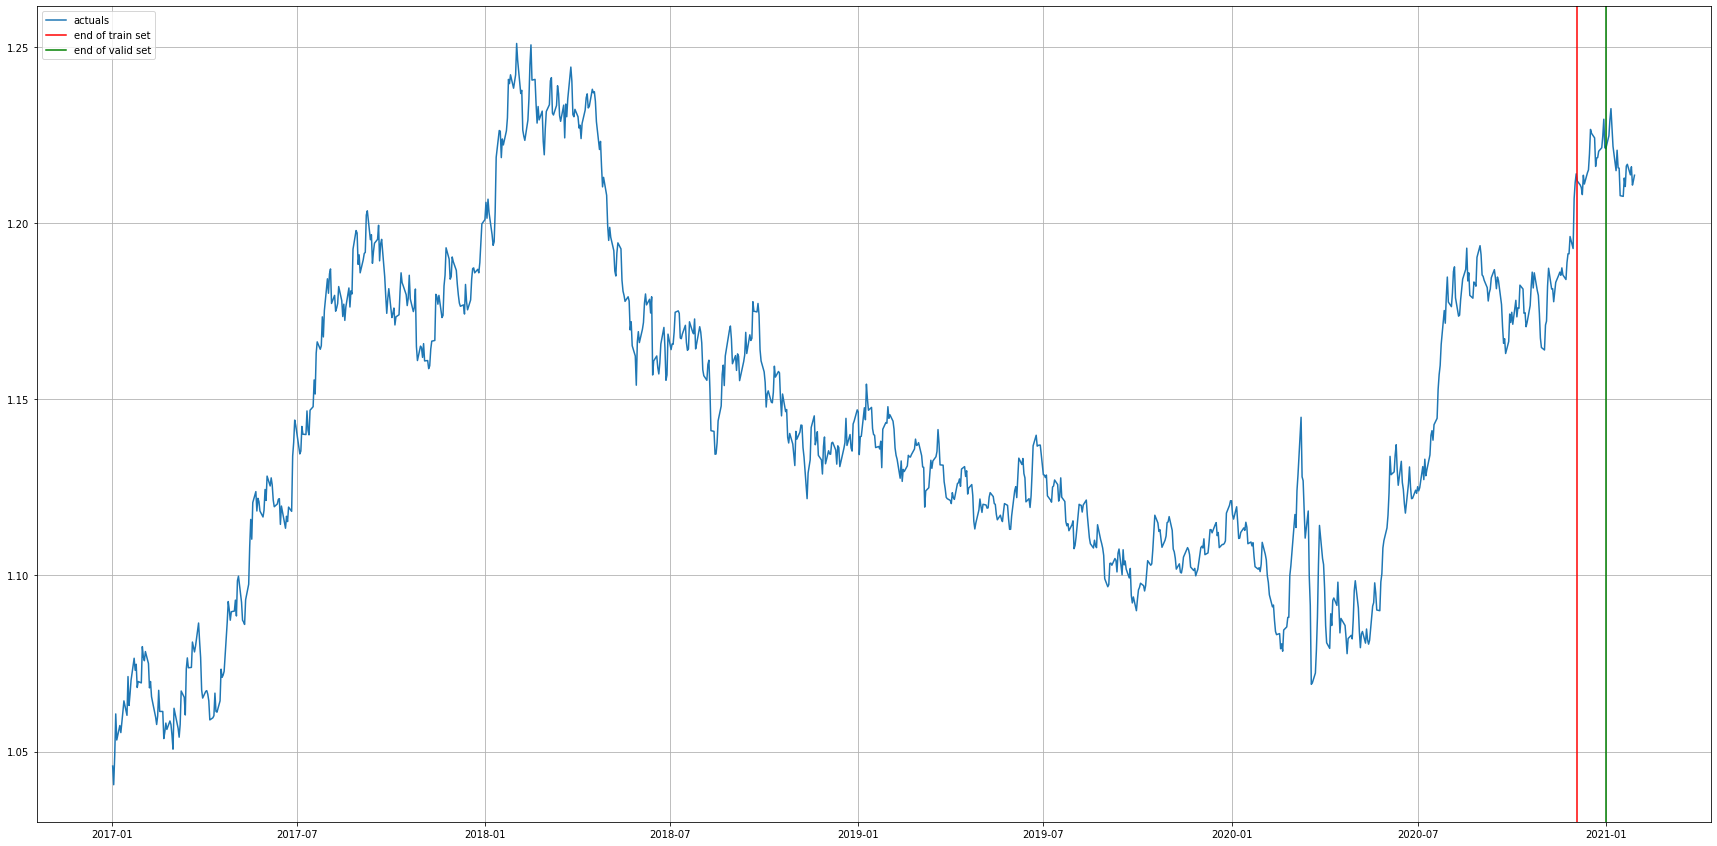

In [66]:
plt.figure(figsize=(30, 15))
plt.plot(inv_data)
plt.axvline(train.index[-1], color='r') # end of train dataset
plt.axvline(valid.index[-1], color='g') # end of valid dataset
plt.grid(which="both")
plt.legend(["actuals", "end of train set", "end of valid set"], loc="upper left")
plt.show()

# GluonTS Helpers

In [67]:
from gluonts.dataset.common import ListDataset


train_df = ListDataset([{'target': train_valid.Price.values, 
                         'start': train_valid.index[0]}], 
                       freq=train_valid.index.freq)

test_df = ListDataset([{'target': inv_data.Price.values, 
                        'start': inv_data.index[0]}],
                      freq=inv_data.index.freq)

In [68]:
from gluonts.evaluation import Evaluator
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions


def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = [50.0, 90.0]
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(30, 15))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

def gluonts_wrapper(estimator, num_samples=100, verbose=True):
    """
    estimator: GluonTS estimator
    num_samples: number of sample paths we want for evaluation
    """
    predictor = estimator.train(train_df)
    forecast_it, ts_it = make_evaluation_predictions(
      dataset=test_df,
      predictor=predictor,
      num_samples=num_samples, 
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)
    forecast_entry = forecasts[0]
    ts_entry = tss[0]

    if verbose:
        print(f"Number of sample paths: {forecast_entry.num_samples}")
        print(f"Dimension of samples: {forecast_entry.samples.shape}")
        print(f"Start date of the forecast window: {forecast_entry.start_date}")
        print(f"Frequency of the time series: {forecast_entry.freq}")

        print(f"Mean of the future window:\n {forecast_entry.mean}")
        print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")
    
    plot_prob_forecasts(ts_entry, forecast_entry)

    evaluator = Evaluator()
    agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_df))
    return agg_metrics
    

# Simple Feed Forward

In [69]:
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator

ff_estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=test_length,
    context_length=100, 
    freq="1B",
    trainer=Trainer(ctx="cpu",
                    epochs=20,
                    learning_rate=1e-3,
                    num_batches_per_epoch=100)
)

  0%|          | 0/100 [00:00<?, ?it/s]WARNING:gluonts.trainer:Batch [3] of Epoch[0] gave NaN loss and it will be ignored


learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 100/100 [00:00<00:00, 112.85it/s, epoch=20/20, avg_epoch_loss=-1.89]


Number of sample paths: 100
Dimension of samples: (100, 20)
Start date of the forecast window: 2021-01-04 00:00:00
Frequency of the time series: 1B
Mean of the future window:
 [1.1902792 1.2204647 1.2124976 1.1997249 1.19808   1.2542781 1.2340939
 1.2917657 1.233088  1.2341648 1.2159016 1.2745676 1.2251287 1.2135341
 1.2579774 1.2408934 1.2213267 1.2249632 1.2758716 1.260408 ]
0.5-quantile (median) of the future window:
 [1.1852789 1.2183934 1.2118943 1.1996646 1.1964953 1.253882  1.2353947
 1.2908425 1.2320195 1.2347616 1.2169697 1.2770416 1.2226422 1.216048
 1.2560998 1.2466835 1.219302  1.2296238 1.2723848 1.2594074]


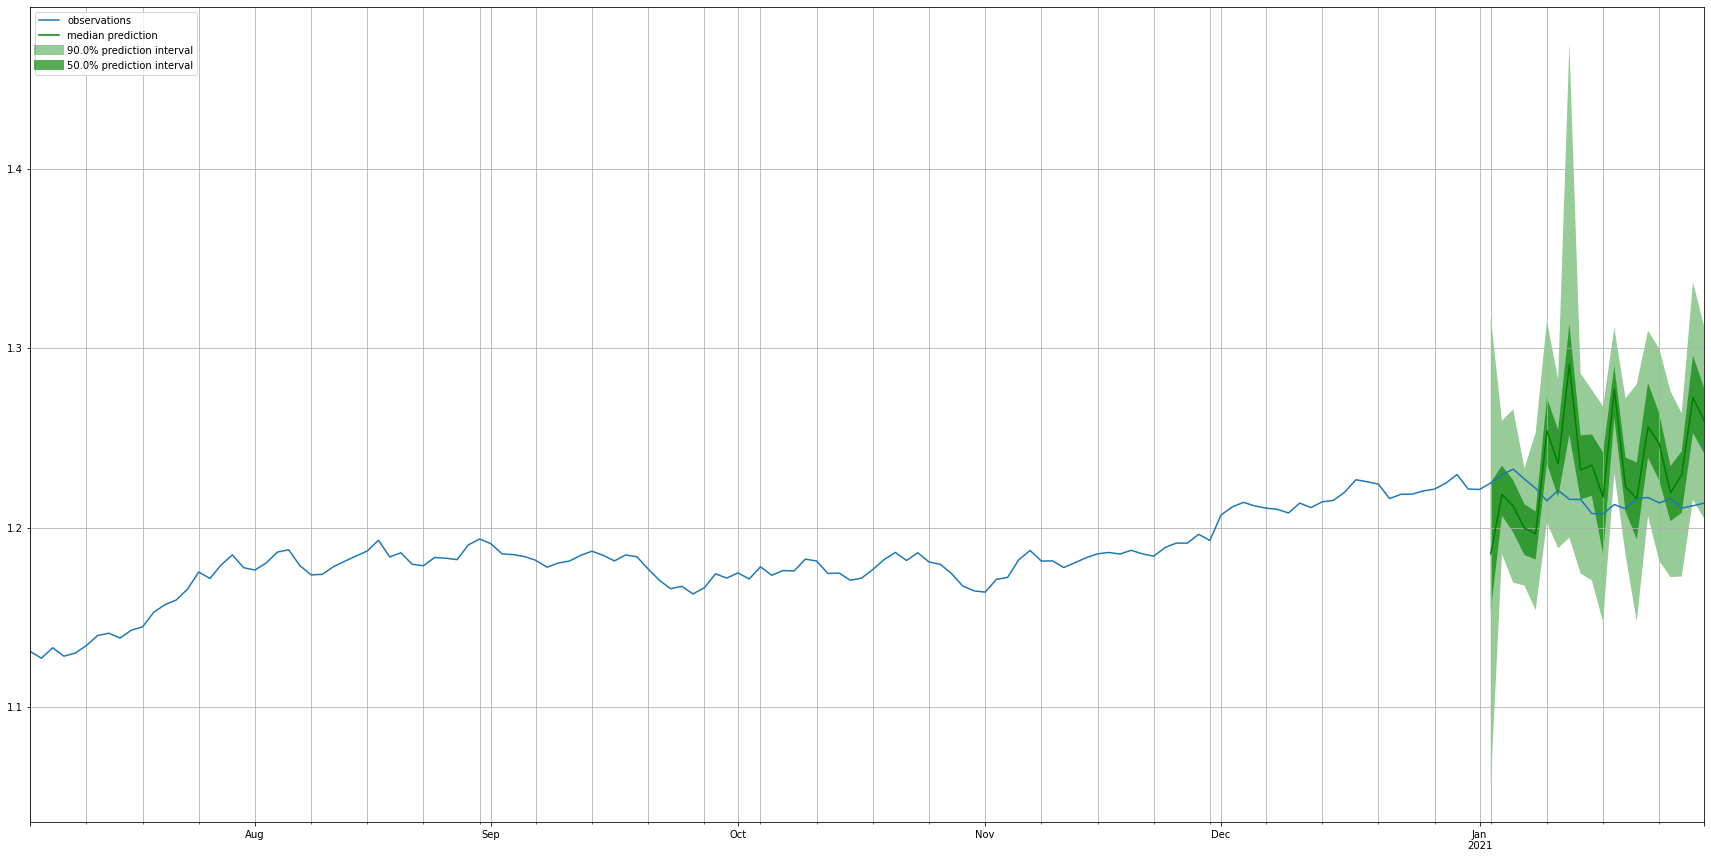

Running evaluation: 100%|██████████| 1/1 [00:00<00:00, 16.34it/s]


In [70]:
agg_metrics_simple_ff = gluonts_wrapper(ff_estimator)

# DeepAR

In [71]:
from gluonts.model.deepar import DeepAREstimator

deepar_estimator = DeepAREstimator(
    freq="1B",
    prediction_length=test_length,   
    trainer=Trainer(epochs=10) 
)

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:03<00:00, 13.40it/s, epoch=10/10, avg_epoch_loss=-2.72]


Number of sample paths: 100
Dimension of samples: (100, 20)
Start date of the forecast window: 2021-01-04 00:00:00
Frequency of the time series: 1B
Mean of the future window:
 [1.2340579 1.2273246 1.2308393 1.2277542 1.227646  1.2270727 1.2248251
 1.2251176 1.2231102 1.2249721 1.2260737 1.2166467 1.2204689 1.2220345
 1.2209744 1.2215874 1.2174938 1.2195224 1.2202458 1.2190294]
0.5-quantile (median) of the future window:
 [1.2342831 1.2291986 1.2310106 1.2276407 1.2258475 1.2286335 1.2241162
 1.2255915 1.2240413 1.2244828 1.2276813 1.2195263 1.2196972 1.222579
 1.2214196 1.2214502 1.2183592 1.2200654 1.2195522 1.219065 ]


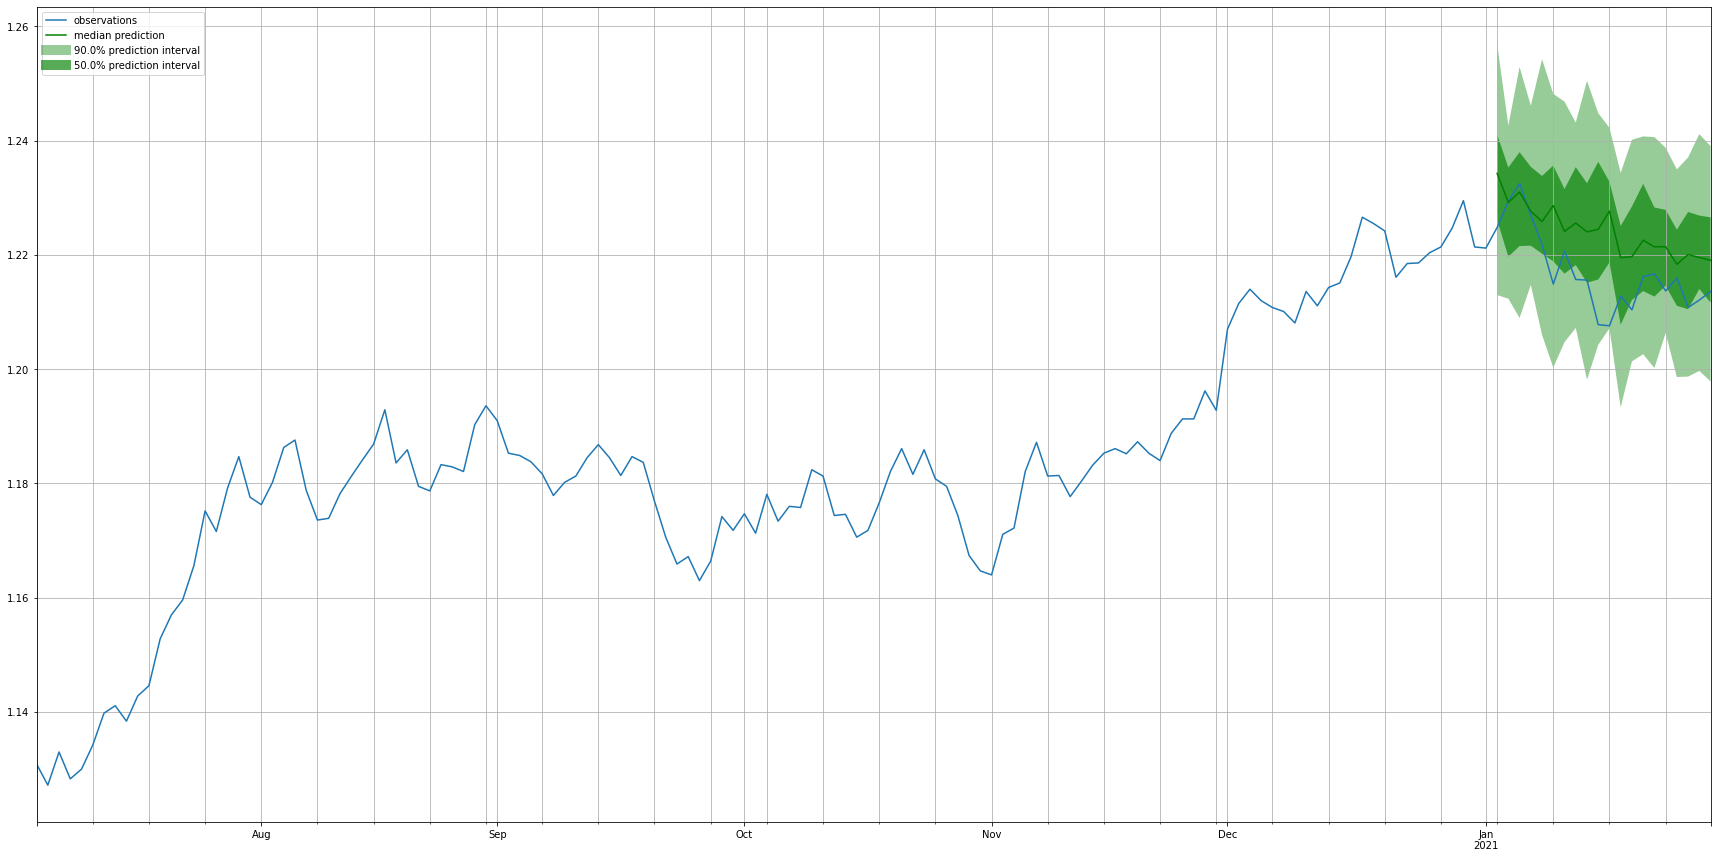

Running evaluation: 100%|██████████| 1/1 [00:00<00:00, 13.87it/s]


In [72]:
agg_metrics_deepar = gluonts_wrapper(deepar_estimator)

# Deep State

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:11<00:00,  4.37it/s, epoch=5/5, avg_epoch_loss=-3.7] 


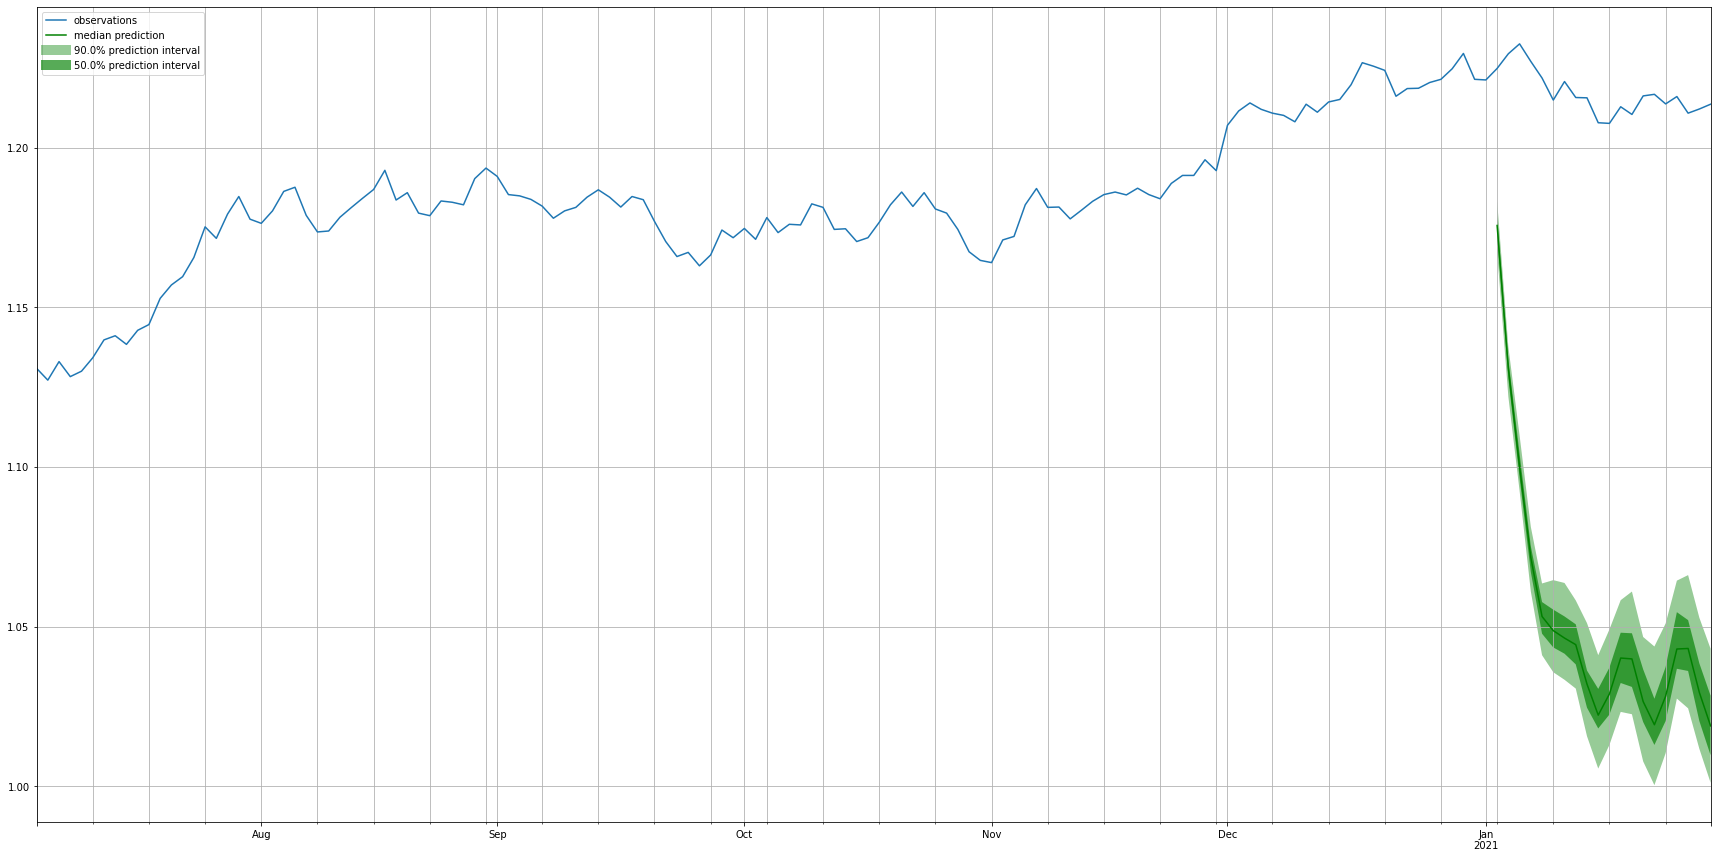

Running evaluation: 100%|██████████| 1/1 [00:00<00:00, 14.38it/s]


In [75]:
from gluonts.model.deepstate import DeepStateEstimator

deepstate_estimator = DeepStateEstimator(
    prediction_length=test_length,
    cardinality=[1],
    freq="1B",
    use_feat_static_cat=False,
    trainer=Trainer(epochs=5))

agg_metrics_deepstate = gluonts_wrapper(deepstate_estimator, verbose=False)

# Deep Factor

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:00<00:00, 75.31it/s, epoch=10/10, avg_epoch_loss=-3.52]


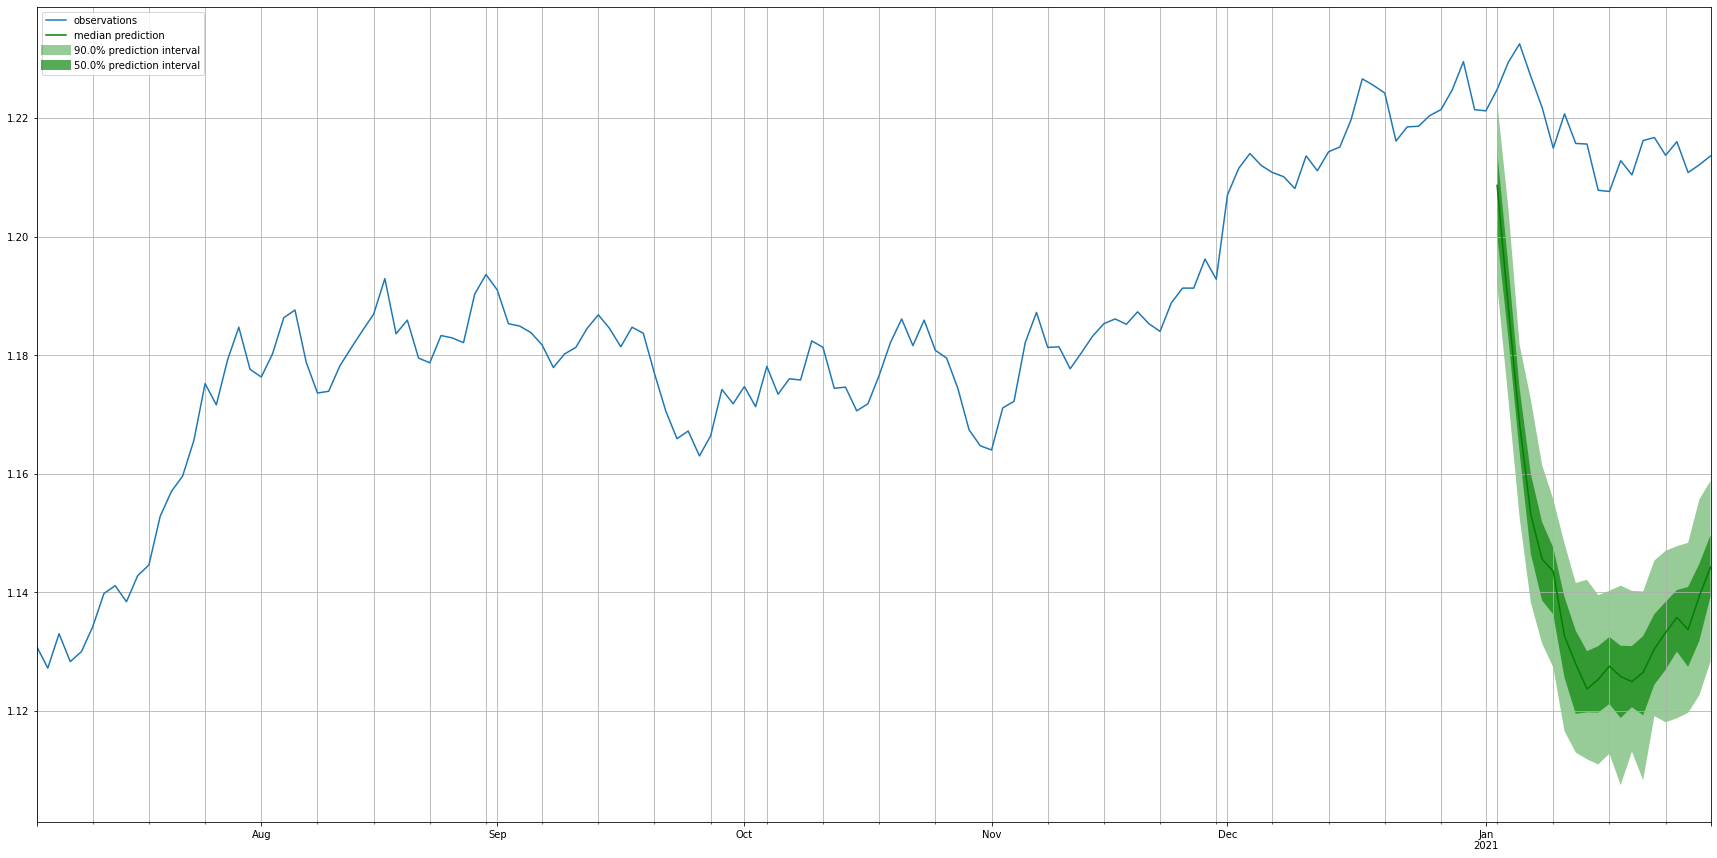

Running evaluation: 100%|██████████| 1/1 [00:00<00:00, 17.48it/s]


In [76]:
from gluonts.model.deep_factor import DeepFactorEstimator

deepfactor_estimator = DeepFactorEstimator(
    freq="1B",
    prediction_length=test_length,
    num_hidden_global=30,
    num_layers_global=2,
    trainer=Trainer(epochs=10))

agg_metrics_deepfactor = gluonts_wrapper(deepfactor_estimator, verbose=False)

# ETS

In [53]:
# I couldn't make this works

# from gluonts.model.r_forecast import RForecastPredictor

# ets_estimator = RForecastPredictor(
#     freq="1B",
#     prediction_length=test_length,
#     method_name="ets")

# predictor_ets = ets_estimator.predict(train_df)

# Comparison

In [77]:
df_metrics = pd.concat(
    [
        pd.DataFrame.from_dict(agg_metrics_simple_ff, orient='index').rename(columns={0: "Simple FF"}),
        pd.DataFrame.from_dict(agg_metrics_deepar, orient='index').rename(columns={0: "DeepAR"}),
        pd.DataFrame.from_dict(agg_metrics_deepstate, orient='index').rename(columns={0: "DeepState"}),
        pd.DataFrame.from_dict(agg_metrics_deepfactor, orient='index').rename(columns={0: "DeepFactor"}),
    ], axis=1)
df_metrics.loc[["MAPE", "RMSE"]]

,Simple FF,DeepAR,DeepState,DeepFactor
MAPE,0.023948,0.006078,0.135567,0.061749
RMSE,0.035024,0.008599,0.167809,0.077290


In [78]:
df_metrics

,Simple FF,DeepAR,DeepState,DeepFactor
MSE,0.001227,0.000074,0.028160,0.005974
abs_error,0.582580,0.147523,3.297166,1.501872
abs_target_sum,24.340099,24.340099,24.340099,24.340099
abs_target_mean,1.217005,1.217005,1.217005,1.217005
seasonal_error,0.008410,0.008410,0.008410,0.008410
MASE,3.463498,0.877037,19.601976,8.928776
MAPE,0.023948,0.006078,0.135567,0.061749
sMAPE,0.023651,0.006051,0.145911,0.063830
OWA,NaN,NaN,NaN,NaN
MSIS,19.349792,6.491863,684.818733,272.945812
